# Final - DTSA 5010
## Problem Statement
My goal with this analysis is to determine if the Vaccine Adverse Event Reporting System (VAERS) data can help predict a patient's outcome given their adverse symptoms or other relevant information from taking a given vaccine.  This will be a binary classification problem where the model's made will determine if the patient DIED (y=1) or LIVED (y=0) from their adverse event report.  However, I want to try using NMF with Unsupervised Machine Learning to solve this problem.  
I am solving this problem in order to better understand the severity of adverse reactions people can have from certain vaccines.

# 1. Exploratory Data Analysis (EDA)

**Dataset**: “VAERS Data Sets”


**Dataset Source**: https://vaers.hhs.gov/data/datasets.html



**Key attributes/dimensions of the data**: 
There are 3 main CSV files associated with this dataset:
1)	*VAERSDATA.csv 
2)	*VAERSSYMPTOMS.csv
3)	*VAERSVAX.csv

These CSV files contain numbers, dates, and other unique values that can be mapped to their Vaccine Adverse Event Reporting System (VAERS) identification number for each person among the spreadsheets.  The VAERS was made by the Food and Drug Administration (FDA) and the Centers for Disease Control and Prevention (CDC) to collect data on adverse reactions that could be associated with vaccines in general.  

I pulled this data on 9/6/2024, which stated the data contains VAERS reports processed as of **08/30/2024**.

I filtered to only include those vaccines related to COVID19.  This dataset includes false positives for adverse reactions given a vaccine due to the encouragement towards doctors and other vaccine providers to report any adverse event if seen regardless of if they can prove the vaccine was the cause.  Therefore, the dataset contains a combination of coincidental events and those truly caused by the vaccine.  

The dataset I downloaded I have shared here on my GDRIVE for people to reproduce my work: 

https://drive.google.com/file/d/13ft2QazL4OugjftllcwjPXLUVMB8-2Xi/view?usp=drive_link

## 1.1 Import Libraries

In [186]:
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import re
import pandas as pd
from nltk.tokenize import word_tokenize
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import altair as alt
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
warnings.filterwarnings("ignore")

## 1.2 Read in Data

In [3]:
MAIN_DIRS = "AllVAERSDataCSVS"
ALL_CSVS = os.listdir(MAIN_DIRS)
VAERSDATA_CSVS = [w for w in ALL_CSVS if w.find("DATA")!=-1 and w.lower().find("nondomestic")==-1]
VAERSSYMP_CSVS = [w for w in ALL_CSVS if w.find("SYMPTOMS")!=-1 and w.lower().find("nondomestic")==-1]
VAERSVAX_CSVS = [w for w in ALL_CSVS if w.find("VAX")!=-1 and w.lower().find("nondomestic")==-1]

In [5]:
for i in range(len(VAERSDATA_CSVS)):
    if i==0:
        df_VAERSDATA = pd.read_csv(os.path.join(MAIN_DIRS,VAERSDATA_CSVS[i]),encoding='ISO-8859-1')
    else:
        df_i = pd.read_csv(os.path.join(MAIN_DIRS,VAERSDATA_CSVS[i]),encoding='ISO-8859-1')
        df_VAERSDATA = pd.concat([df_VAERSDATA,df_i],axis=0)
        df_VAERSDATA = df_VAERSDATA.reset_index().drop("index",axis=1)

In [6]:
df_VAERSDATA

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,25001,07/02/1990,WI,0.20,NaN,NaN,F,NaN,Loud intense cry with screaming for 1 1/2 hrs....,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,25003,07/02/1990,TX,0.80,NaN,NaN,M,NaN,"Hypotonic, Hyporesponsive episode, Infant died...",Y,...,NaN,NaN,~ ()~~~In patient,NaN,1,NaN,NaN,NaN,NaN,NaN
2,25004,07/02/1990,NY,0.90,NaN,NaN,M,NaN,"Pt developed chills for approx. 1 hr, felt ach...",NaN,...,NaN,NaN,~ ()~~~In patient,890269201,1,NaN,NaN,NaN,NaN,NaN
3,25005,07/02/1990,OK,NaN,NaN,NaN,U,NaN,7 patients within 2 weeks have reported joint ...,NaN,...,NaN,NaN,~ ()~~~In patient,890277901,1,NaN,NaN,NaN,NaN,NaN
4,25006,07/02/1990,OH,16.00,16.0,NaN,F,NaN,16 yr old female feeling faint & then had seiz...,NaN,...,NaN,no hx of local or systemic rxns,~ ()~~~In patient,890278001,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855857,2787668,08/30/2024,IN,37.00,37.0,NaN,F,NaN,"Skin reactions, allergies, muscle weakness, bo...",NaN,...,NaN,"Arthrisis, mild- moderate headaches, endometri...",NaN,NaN,2,08/30/2024,Y,Y,NaN,Tramadol
1855858,2787674,08/30/2024,GA,0.25,0.0,0.3,U,NaN,No additional AE/No PQC.; HCP reported that RE...,NaN,...,NaN,NaN,NaN,US0095075132408USA010106,2,08/30/2024,NaN,NaN,NaN,NaN
1855859,2787675,08/30/2024,NY,NaN,NaN,NaN,F,NaN,Shingles outbreak after vaccination; This non-...,NaN,...,NaN,NaN,NaN,USGSKUS2024105377,2,08/30/2024,NaN,NaN,NaN,NaN
1855860,2787676,08/30/2024,KS,0.17,0.0,0.2,M,NaN,nurse stated that she accidentally gave ACTHIB...,NaN,...,NaN,NaN,NaN,USSA2024SA252142,2,08/30/2024,NaN,NaN,NaN,NaN


In [7]:
for i in range(len(VAERSSYMP_CSVS)):
    if i==0:
        df_VAERSSYMPTOMS = pd.read_csv(os.path.join(MAIN_DIRS,VAERSSYMP_CSVS[i]),encoding='ISO-8859-1')
    else:
        df_i = pd.read_csv(os.path.join(MAIN_DIRS,VAERSSYMP_CSVS[i]),encoding='ISO-8859-1')
        df_VAERSSYMPTOMS = pd.concat([df_VAERSSYMPTOMS,df_i],axis=0)
        df_VAERSSYMPTOMS = df_VAERSSYMPTOMS.reset_index().drop("index",axis=1)

In [8]:
df_VAERSSYMPTOMS

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,25001,Agitation,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25003,Delirium,8.1,Hypokinesia,8.1,Hypotonia,8.1,NaN,NaN,NaN,NaN
2,25004,Chills,8.1,Dermatitis contact,8.1,Oedema genital,8.1,Pelvic pain,8.1,NaN,NaN
3,25005,Arthritis,8.1,Injection site oedema,8.1,Injection site reaction,8.1,NaN,NaN,NaN,NaN
4,25006,Convulsion,8.1,Dizziness,8.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2362321,2787677,Muscle spasms,27.0,Musculoskeletal stiffness,27.0,Pain,27.0,Pain in extremity,27.0,Periarthritis,27.0
2362322,2787677,Physical disability,27.0,Product administered at inappropriate site,27.0,Shoulder injury related to vaccine administration,27.0,Sleep disorder,27.0,Tendonitis,27.0
2362323,2787677,Wrong technique in product usage process,27.0,X-ray limb abnormal,27.0,NaN,NaN,NaN,NaN,NaN,NaN
2362324,2787678,Tinnitus,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for i in range(len(VAERSVAX_CSVS)):
    if i==0:
        df_VAERSVAX = pd.read_csv(os.path.join(MAIN_DIRS,VAERSVAX_CSVS[i]),encoding='ISO-8859-1')
    else:
        df_i = pd.read_csv(os.path.join(MAIN_DIRS,VAERSVAX_CSVS[i]),encoding='ISO-8859-1')
        df_VAERSVAX = pd.concat([df_VAERSVAX,df_i],axis=0)
        df_VAERSVAX = df_VAERSVAX.reset_index().drop("index",axis=1)

In [10]:
df_VAERSVAX

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,25001,DTP,CONNAUGHT LABORATORIES,9Q01042,UNK,IM,NaN,DTP (NO BRAND NAME)
1,25003,DTP,LEDERLE LABORATORIES,259962,4,IM,NaN,DTP (TRI-IMMUNOL)
2,25003,OPV,PFIZER\WYETH,241950,4,PO,MO,"POLIO VIRUS, ORAL (ORIMUNE)"
3,25004,OPV,PFIZER\WYETH,232961,UNK,NaN,NaN,"POLIO VIRUS, ORAL (ORIMUNE)"
4,25005,TD,LEDERLE LABORATORIES,247955,UNK,IM,NaN,TD ADSORBED (NO BRAND NAME)
...,...,...,...,...,...,...,...,...
2333262,2787678,MENB,NOVARTIS VACCINES AND DIAGNOSTICS,G334J,1,NaN,RA,MENINGOCOCCAL B (BEXSERO)
2333263,2787678,MNQ,SANOFI PASTEUR,U8284AB,UNK,NaN,LA,MENINGOCOCCAL CONJUGATE (MENQUADFI)
2333264,2787679,DTAPIPV,SANOFI PASTEUR,U8009AB,UNK,IM,LL,DTAP + IPV (QUADRACEL)
2333265,2787679,MMR,MERCK & CO. INC.,X019107,UNK,SC,RL,MEASLES + MUMPS + RUBELLA (MMR II)


In [18]:
df_COMBINED = pd.merge(df_VAERSDATA,df_VAERSSYMPTOMS,on=["VAERS_ID"])
df_COMBINED = pd.merge(df_COMBINED,df_VAERSVAX,on=["VAERS_ID"])
df_COMBINED.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,25001,07/02/1990,WI,0.2,NaN,NaN,F,NaN,Loud intense cry with screaming for 1 1/2 hrs....,NaN,...,NaN,NaN,NaN,DTP,CONNAUGHT LABORATORIES,9Q01042,UNK,IM,NaN,DTP (NO BRAND NAME)
1,25003,07/02/1990,TX,0.8,NaN,NaN,M,NaN,"Hypotonic, Hyporesponsive episode, Infant died...",Y,...,NaN,NaN,NaN,DTP,LEDERLE LABORATORIES,259962,4,IM,NaN,DTP (TRI-IMMUNOL)
2,25003,07/02/1990,TX,0.8,NaN,NaN,M,NaN,"Hypotonic, Hyporesponsive episode, Infant died...",Y,...,NaN,NaN,NaN,OPV,PFIZER\WYETH,241950,4,PO,MO,"POLIO VIRUS, ORAL (ORIMUNE)"
3,25004,07/02/1990,NY,0.9,NaN,NaN,M,NaN,"Pt developed chills for approx. 1 hr, felt ach...",NaN,...,8.1,NaN,NaN,OPV,PFIZER\WYETH,232961,UNK,NaN,NaN,"POLIO VIRUS, ORAL (ORIMUNE)"
4,25005,07/02/1990,OK,NaN,NaN,NaN,U,NaN,7 patients within 2 weeks have reported joint ...,NaN,...,NaN,NaN,NaN,TD,LEDERLE LABORATORIES,247955,UNK,IM,NaN,TD ADSORBED (NO BRAND NAME)


In [19]:
df_COMBINED = df_COMBINED.drop_duplicates(["SYMPTOM_TEXT"])

In [20]:
df_COMBINED["DAYS_to_DEATH"] = pd.to_datetime(df_COMBINED.DATEDIED) - pd.to_datetime(df_COMBINED.VAX_DATE)
df_COMBINED["DAYS_to_DEATH"] = df_COMBINED["DAYS_to_DEATH"] /np.timedelta64(1,"D")

In [21]:
df_COMBINED = df_COMBINED.reset_index().drop("index",axis=1)
df_COMBINED

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,SYMPTOM5,SYMPTOMVERSION5,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,DAYS_to_DEATH
0,25001,07/02/1990,WI,0.20,NaN,NaN,F,NaN,Loud intense cry with screaming for 1 1/2 hrs....,NaN,...,NaN,NaN,DTP,CONNAUGHT LABORATORIES,9Q01042,UNK,IM,NaN,DTP (NO BRAND NAME),NaN
1,25003,07/02/1990,TX,0.80,NaN,NaN,M,NaN,"Hypotonic, Hyporesponsive episode, Infant died...",Y,...,NaN,NaN,DTP,LEDERLE LABORATORIES,259962,4,IM,NaN,DTP (TRI-IMMUNOL),NaN
2,25004,07/02/1990,NY,0.90,NaN,NaN,M,NaN,"Pt developed chills for approx. 1 hr, felt ach...",NaN,...,NaN,NaN,OPV,PFIZER\WYETH,232961,UNK,NaN,NaN,"POLIO VIRUS, ORAL (ORIMUNE)",NaN
3,25005,07/02/1990,OK,NaN,NaN,NaN,U,NaN,7 patients within 2 weeks have reported joint ...,NaN,...,NaN,NaN,TD,LEDERLE LABORATORIES,247955,UNK,IM,NaN,TD ADSORBED (NO BRAND NAME),NaN
4,25006,07/02/1990,OH,16.00,16.0,NaN,F,NaN,16 yr old female feeling faint & then had seiz...,NaN,...,NaN,NaN,MMR,UNKNOWN MANUFACTURER,NaN,UNK,NaN,NaN,MEASLES + MUMPS + RUBELLA (NO BRAND NAME),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729649,2787665,08/30/2024,OK,4.00,NaN,NaN,U,NaN,there are no symptomatic adverse events report...,NaN,...,NaN,NaN,HPV9,MERCK & CO. INC.,W015894,UNK,NaN,NaN,HPV (GARDASIL 9),NaN
1729650,2787668,08/30/2024,IN,37.00,37.0,NaN,F,NaN,"Skin reactions, allergies, muscle weakness, bo...",NaN,...,Arthritis,27.0,COVID19,PFIZER\BIONTECH,Ew0153,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
1729651,2787674,08/30/2024,GA,0.25,0.0,0.3,U,NaN,No additional AE/No PQC.; HCP reported that RE...,NaN,...,NaN,NaN,DTAPHEPBIP,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,DTAP + HEPB + IPV (PEDIARIX),NaN
1729652,2787675,08/30/2024,NY,NaN,NaN,NaN,F,NaN,Shingles outbreak after vaccination; This non-...,NaN,...,NaN,NaN,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,UNK,UNK,NaN,NaN,ZOSTER (SHINGRIX),NaN


In [22]:
sorted(list(df_COMBINED.columns))

['AGE_YRS',
 'ALLERGIES',
 'BIRTH_DEFECT',
 'CAGE_MO',
 'CAGE_YR',
 'CUR_ILL',
 'DATEDIED',
 'DAYS_to_DEATH',
 'DIED',
 'DISABLE',
 'ER_ED_VISIT',
 'ER_VISIT',
 'FORM_VERS',
 'HISTORY',
 'HOSPDAYS',
 'HOSPITAL',
 'LAB_DATA',
 'L_THREAT',
 'NUMDAYS',
 'OFC_VISIT',
 'ONSET_DATE',
 'OTHER_MEDS',
 'PRIOR_VAX',
 'RECOVD',
 'RECVDATE',
 'RPT_DATE',
 'SEX',
 'SPLTTYPE',
 'STATE',
 'SYMPTOM1',
 'SYMPTOM2',
 'SYMPTOM3',
 'SYMPTOM4',
 'SYMPTOM5',
 'SYMPTOMVERSION1',
 'SYMPTOMVERSION2',
 'SYMPTOMVERSION3',
 'SYMPTOMVERSION4',
 'SYMPTOMVERSION5',
 'SYMPTOM_TEXT',
 'TODAYS_DATE',
 'VAERS_ID',
 'VAX_DATE',
 'VAX_DOSE_SERIES',
 'VAX_LOT',
 'VAX_MANU',
 'VAX_NAME',
 'VAX_ROUTE',
 'VAX_SITE',
 'VAX_TYPE',
 'V_ADMINBY',
 'V_FUNDBY',
 'X_STAY']

In [23]:
sorted(df_COMBINED.VAX_TYPE.unique())

['6VAX-F',
 'ADEN',
 'ADEN_4_7',
 'ANTH',
 'BCG',
 'CEE',
 'CHIK',
 'CHOL',
 'COVID19',
 'COVID19-2',
 'DF',
 'DPP',
 'DT',
 'DTAP',
 'DTAPH',
 'DTAPHEPBIP',
 'DTAPIPV',
 'DTAPIPVHIB',
 'DTIPV',
 'DTOX',
 'DTP',
 'DTPHEP',
 'DTPHIB',
 'DTPIHI',
 'DTPIPV',
 'DTPPHIB',
 'DTPPVHBHPB',
 'EBZR',
 'FLU(H1N1)',
 'FLU3',
 'FLU4',
 'FLUA3',
 'FLUA4',
 'FLUC3',
 'FLUC4',
 'FLUN(H1N1)',
 'FLUN3',
 'FLUN4',
 'FLUR3',
 'FLUR4',
 'FLUX',
 'FLUX(H1N1)',
 'H5N1',
 'HBHEPB',
 'HBPV',
 'HEP',
 'HEPA',
 'HEPAB',
 'HEPATYP',
 'HIBV',
 'HPV2',
 'HPV4',
 'HPV9',
 'HPVX',
 'IPV',
 'JEV',
 'JEV1',
 'JEVX',
 'LYME',
 'MEA',
 'MEN',
 'MENB',
 'MENHIB',
 'MER',
 'MM',
 'MMR',
 'MMRV',
 'MNP',
 'MNQ',
 'MNQHIB',
 'MU',
 'MUR',
 'OPV',
 'PER',
 'PLAGUE',
 'PNC',
 'PNC10',
 'PNC13',
 'PNC15',
 'PNC20',
 'PPV',
 'RAB',
 'RSV',
 'RUB',
 'RV',
 'RV1',
 'RV5',
 'RVX',
 'SMALL',
 'SMALLMNK',
 'SSEV',
 'TBE',
 'TD',
 'TDAP',
 'TTOX',
 'TYP',
 'UNK',
 'VARCEL',
 'VARZOS',
 'YF']

In [24]:
df_COVID = df_COMBINED[df_COMBINED.VAX_TYPE.str.lower().str.find("covid")!=-1]
df_COVID = df_COVID.reset_index().drop("index",axis=1)

In [25]:
df_COVID['VAX_MANU'] = df_COVID.groupby('VAX_LOT')['VAX_MANU'].transform(lambda x: x.mode()[0])

In [26]:
df_COVID['VAX_TYPE'] = df_COVID.groupby('VAX_LOT')['VAX_TYPE'].transform(lambda x: x.mode()[0])

In [27]:
df_COVID.to_csv("df_COVID.csv",index=None)

## 1.3 Data Cleaning

In [32]:
df_COVID.describe()

,VAERS_ID,AGE_YRS,CAGE_YR,CAGE_MO,HOSPDAYS,NUMDAYS,FORM_VERS,SYMPTOMVERSION1,SYMPTOMVERSION2,SYMPTOMVERSION3,SYMPTOMVERSION4,SYMPTOMVERSION5,DAYS_to_DEATH
count,9.107910e+05,809846.000000,709781.000000,4258.000000,49154.000000,778506.000000,910791.000000,910791.000000,743379.000000,573924.000000,432266.000000,324771.000000,14905.000000
mean,1.664290e+06,50.267979,49.882389,0.338633,10.544778,43.859819,1.998932,24.239516,24.241974,24.228382,24.214482,24.226294,154.023818
std,5.330600e+05,19.821425,20.087632,0.330600,639.878373,610.399894,0.032667,0.652729,0.656992,0.647661,0.637458,0.645407,846.582838
min,9.024180e+05,0.080000,0.000000,0.000000,1.000000,0.000000,1.000000,23.100000,23.100000,23.100000,23.100000,23.100000,-36523.000000
25%,1.201110e+06,35.000000,35.000000,0.000000,2.000000,0.000000,2.000000,24.000000,24.000000,24.000000,24.000000,24.000000,13.000000
50%,1.587323e+06,51.000000,51.000000,0.300000,4.000000,1.000000,2.000000,24.000000,24.000000,24.000000,24.000000,24.000000,86.000000
75%,2.075621e+06,66.000000,66.000000,0.600000,7.000000,8.000000,2.000000,24.100000,24.100000,24.100000,24.100000,24.100000,231.000000
max,2.787668e+06,119.000000,120.000000,1.000000,99999.000000,44224.000000,2.000000,27.000000,27.000000,27.000000,27.000000,27.000000,36896.000000


In [33]:
print(df_COVID.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            769136 non-null  object 
 3   AGE_YRS          809846 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             17244 non-null   object 
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         79771 non-null   object 
 14  HOSPDAYS         49154 non-null   float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

In [34]:
#We can assume 'UNKNOWN' for object or str types that we dont know otherwise.
df_COVID['SEX'].fillna('Unknown', inplace=True) 
df_COVID['STATE'].fillna('Unknown', inplace=True)
df_COVID['VAX_LOT'].fillna('Unknown', inplace=True)
df_COVID['VAX_MANU'].fillna('Unknown', inplace=True)
df_COVID['VAX_SITE'].fillna('Unknown', inplace=True)
df_COVID['AGE_YRS'].fillna(df_COVID['AGE_YRS'].median(), inplace=True) #assume that the median age can be imputed for these values
df_COVID['ALLERGIES'].fillna('', inplace=True)  
df_COVID['HISTORY'].fillna('', inplace=True)  
df_COVID['CUR_ILL'].fillna('', inplace=True)  
df_COVID['SYMPTOMS'] = df_COVID[['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']].fillna('').apply(lambda x: ' '.join(x), axis=1)
df_COVID.SYMPTOMS = [w.lower() for w in df_COVID.SYMPTOMS]
df_COVID['SYMPTOMS'].fillna('', inplace=True)  
df_COVID['HOSPDAYS'].fillna(0.,inplace=True)

In [35]:
print(df_COVID.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 54 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            910791 non-null  object 
 3   AGE_YRS          910791 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             17244 non-null   object 
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         79771 non-null   object 
 14  HOSPDAYS         910791 non-null  float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

In [36]:
def cleanup_text(df, text_col,clean_col="clean_text",stopwords=stopwords):
    stop_words = stopwords.words('english')
    df[clean_col] = df[text_col].copy() #copy original text to clean_text for cleaning
    df[clean_col] = [re.sub(r'[^\w\s]+','',w) for w in df[clean_col]]#cleanup punctuations
    df[clean_col] = [re.sub(r'[0-9]+','',w) for w in df[clean_col]]#cleanup numbers
    df[clean_col] = df[clean_col].apply(lambda w: ' '.join([word for word in w.split() if word not in (stop_words)])) #remove stopwords
    df[clean_col] = [re.sub(' +',' ',w) for w in df[clean_col]] #remove abnormal spacing
    return df

In [37]:
df_COVID_clean = cleanup_text(df_COVID,"SYMPTOMS","clean_text")


In [41]:
df_COVID = df_COVID_clean.drop("SYMPTOMS",axis=1).rename(columns={"clean_text":"SYMPTOMS"}) #make it our clean one

In [42]:
# Define features we might want to look at
categorical_features = ['SEX', 'STATE', 'VAX_LOT', 'VAX_MANU', 'VAX_SITE',"HOSPITAL"]
numerical_features = ['AGE_YRS',"HOSPDAYS"]
text_feature_allergies = 'ALLERGIES'
text_feature_HISTORY = 'HISTORY'
text_feature_CUR_ILL = "CUR_ILL"
text_feature_symptoms = 'SYMPTOMS'  




df_COVID['HOSPITAL'] = df_COVID['HOSPITAL'].apply(lambda x: 1 if pd.notnull(x) else 0)

df_COVID['DIED'] = df_COVID['DIED'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [43]:
df_COVID[numerical_features+["DIED"]].corr().reset_index().melt('index')

,index,variable,value
0,AGE_YRS,AGE_YRS,1.000000
1,HOSPDAYS,AGE_YRS,0.003181
2,DIED,AGE_YRS,0.154165
3,AGE_YRS,HOSPDAYS,0.003181
4,HOSPDAYS,HOSPDAYS,1.000000
5,DIED,HOSPDAYS,0.002571
6,AGE_YRS,DIED,0.154165
7,HOSPDAYS,DIED,0.002571
8,DIED,DIED,1.000000


In [44]:
df_COVID[numerical_features+["DIED"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGE_YRS   910791 non-null  float64
 1   HOSPDAYS  910791 non-null  float64
 2   DIED      910791 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 20.8 MB


In [45]:
df_COVID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 54 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            910791 non-null  object 
 3   AGE_YRS          910791 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             910791 non-null  int64  
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         910791 non-null  int64  
 14  HOSPDAYS         910791 non-null  float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

We can visualize if any of the words are highly correlated with the patient dieing using TFID

**SYMPTOMS**

In [46]:
KEYWORD = "SYMPTOMS"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from SYMPTOMS
death           0.801784
acute           0.140926
covid           0.116855
cardiac         0.100493
respiratory     0.098832
failure         0.087554
positive        0.054081
dyspnoea        0.029131
sarscov         0.023226
xray            0.022863
aggravated      0.017023
condition       0.016886
asthenia        0.015830
abnormal        0.015058
infection       0.013436
tomogram        0.009753
computerised    0.009746
test            0.007862
cough           0.005906
blood           0.003156
Name: DIED, dtype: float64
Top 20 negative correlated words from SYMPTOMS
feeling        -0.024535
discomfort     -0.024825
myalgia        -0.026459
nausea         -0.027744
arthralgia     -0.029388
extremity      -0.030807
pruritus       -0.031175
rash           -0.031527
pyrexia        -0.031878
erythema       -0.032089
swelling       -0.032319
dizziness      -0.034976
administered   -0.035834
product        -0.037273
injection      -0.040490
chill

alt.Chart(...)

That is a significant **leakage** word, *death*.  We will remove it later to prevent data leakage.

**HISTORY**

In [47]:
KEYWORD = "HISTORY"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from HISTORY
failure           0.091570
htn               0.078724
cad               0.073180
copd              0.067407
stage             0.060421
dm                0.053836
fibrillation      0.051160
hyperlipidemia    0.045558
atrial            0.045485
artery            0.043895
disease           0.043422
coronary          0.041837
mellitus          0.040119
chronic           0.039813
pulmonary         0.038694
kidney            0.036596
lung              0.036535
heart             0.036499
acute             0.035756
unspecified       0.034841
Name: DIED, dtype: float64
Top 20 negative correlated words from HISTORY
seasonal      -0.009162
penicillin    -0.009682
cholesterol   -0.009744
provided      -0.010197
reporter      -0.010244
blood         -0.010614
pressure      -0.010659
comments      -0.012057
migraines     -0.012117
list          -0.012750
high          -0.013140
encoded       -0.014287
relevant      -0.014685
allergies     -0.016556
allerg

alt.Chart(...)

**CUR_ILL**

In [48]:
KEYWORD = "CUR_ILL"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from CUR_ILL
failure           0.055522
unknown           0.046462
acute             0.027771
copd              0.026432
htn               0.023271
heart             0.022184
chronic           0.021401
hyperlipidemia    0.019530
anemia            0.016397
21                0.016300
kidney            0.016267
disease           0.015299
uti               0.013749
19                0.013511
type              0.013202
diabetes          0.012870
cancer            0.012790
unspecified       0.012514
hypertension      0.011930
2021              0.011821
Name: DIED, dtype: float64
Top 20 negative correlated words from CUR_ILL
arthritis      -0.003038
alcohol        -0.003272
years          -0.003547
allergic       -0.003739
fibromyalgia   -0.003889
verbatim       -0.003979
cholesterol    -0.003984
migraine       -0.004095
abstains       -0.004148
na             -0.004320
penicillin     -0.004353
denies         -0.004615
sinus          -0.005068
asthma         -0

alt.Chart(...)

**ALLERGIES**

In [49]:
KEYWORD = "ALLERGIES"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from ALLERGIES
unknown        0.050929
penicillins    0.017033
known          0.014771
nkda           0.014419
nka            0.014084
lisinopril     0.011092
allergies      0.010466
reaction       0.008065
reported       0.006995
oxycodone      0.006622
nausea         0.005335
swelling       0.004784
cephalexin     0.004664
itching        0.003392
vomiting       0.003227
tramadol       0.003173
codeine        0.002976
drug           0.002706
rash           0.002389
adhesive       0.002084
Name: DIED, dtype: float64
Top 20 negative correlated words from ALLERGIES
peanuts       -0.005591
wheat         -0.005973
cats          -0.006095
sensitivity   -0.006320
pollen        -0.006436
dust          -0.006604
nuts          -0.006723
tree          -0.006788
mold          -0.007062
dairy         -0.007530
shellfish     -0.007712
seasonal      -0.008203
amoxicillin   -0.008476
drugs         -0.008746
gluten        -0.009182
allergic      -0.009233
allergy       

alt.Chart(...)

In [50]:
KEYWORD = "SYMPTOM_TEXT"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from SYMPTOM_TEXT
positive       0.099745
covid          0.099335
21             0.097907
2021           0.088186
patient        0.044969
2022           0.044568
12             0.036367
10             0.028637
medical        0.024266
19             0.021304
event          0.013414
prior          0.011748
case           0.011662
reported       0.008590
date           0.005771
blood          0.005705
unspecified    0.002359
30             0.001998
time           0.001036
pfizer        -0.001089
Name: DIED, dtype: float64
Top 20 negative correlated words from SYMPTOM_TEXT
dosage        -0.032351
sore          -0.032480
dose          -0.032988
experienced   -0.033309
rash          -0.033761
left          -0.034168
included      -0.034440
1273          -0.034684
describes     -0.035276
occurrence    -0.035415
body          -0.035700
chills        -0.037103
concomitant   -0.037397
mrna          -0.038153
outcome       -0.039827
pain          -0.042031
site    

alt.Chart(...)

                 VAX_LOT_encoded  SEX_encoded      DIED
VAX_LOT_encoded         1.000000     0.073659 -0.018087
SEX_encoded             0.073659     1.000000  0.065482
DIED                   -0.018087     0.065482  1.000000


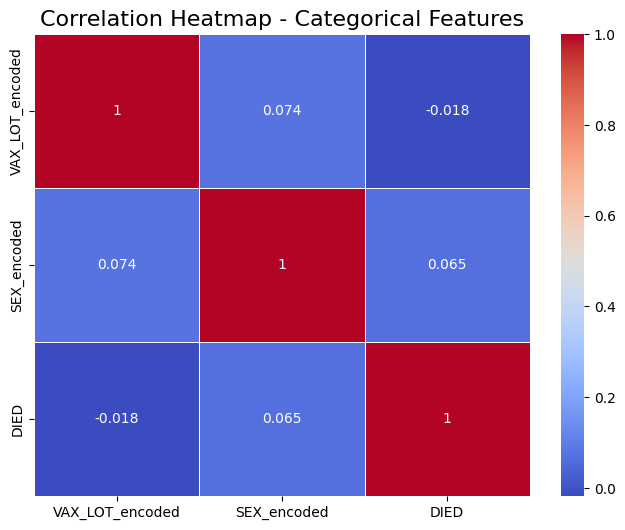

In [90]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
label_encoder = LabelEncoder()

df_COVID['VAX_LOT_encoded'] = label_encoder.fit_transform(df_COVID['VAX_LOT'])
df_COVID['SEX_encoded'] = label_encoder.fit_transform(df_COVID['SEX'])
correlation_matrix = df_COVID[['VAX_LOT_encoded', 'SEX_encoded','DIED']].corr()

print(correlation_matrix)

corr_matrix = correlation_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Categorical Features', fontsize=16)
plt.show()

* Look for data leakage by keywords in the **SYMPTOMS** that might indicate they died like *death*.  

In [ ]:
df_COVID[(df_COVID.SYMPTOMS.str.contains("death")) & (df_COVID.DIED==1)] #Does include 'death' 

In [ ]:
list(df_COVID[(df_COVID.SYMPTOMS.str.lower().str.contains("death")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

In [ ]:
df_COVID[(~df_COVID.SYMPTOMS.str.contains("death")) & (df_COVID.DIED==1)] #Does NOT include 'death' 

In [ ]:
list(df_COVID[(~df_COVID.SYMPTOMS.str.lower().str.contains("death")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

In [ ]:
list(df_COVID[df_COVID.SYMPTOMS.str.contains("autopsy")].SYMPTOMS)[0:20] #Another leaky word, 'autopsy'

* We will cleanup the data some more so that we don't leak the truth into the training features.  We will remove rows with SYMPTOMS containing 'death' and 'autopsy'.  

In [ ]:
df_COVID = df_COVID[(~df_COVID.SYMPTOMS.str.contains("death")) & (~df_COVID.SYMPTOMS.str.contains("autopsy"))].reset_index().drop("index",axis=1)
df_COVID

## 1.4 Key-Insights

* It appears that a good chunk of the symptoms contain the word 'covid', which indicates a lot of these people who received the vaccine still got 'covid'.

In [ ]:
print(len(list(df_COVID[df_COVID.SYMPTOMS.str.contains("covid")].SYMPTOMS)))

In [ ]:
list(df_COVID[df_COVID.SYMPTOMS.str.contains("covid")].SYMPTOMS)[0:20]

In fact, it appears that a significant amount of them even died with COVID.

In [ ]:
print(len(list(df_COVID[(df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)))

In [ ]:
list(df_COVID[(df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

Of the people that died, there was still a good amount of them that died without COVID and was correlated with the vaccine.

In [ ]:
print(len(list(df_COVID[(~df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)))

In [ ]:
list(df_COVID[(~df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOM_TEXT)[0:20]

# 2. Analysis - Model Building/Training

## 2.1 Unsupervised Approach - NMF

* In order to use Non-Matrix Factorization (NMF), a unsupervised ML approach to predict the category from the text, we need to do an exhaustive search on the different permutations that our *n_components* could give us.  Therefore, we will make a *label_permute_score* and integrate it into a class we super from *sklearn* in order to train the model with *GridSearchCV*.

* Also, we will do **hyperparameter** tuning based on the *l1_ratio*, *init*, *solver*, and *beta_loss* for NMF.  When exploring these hyperparameters with GridSearchCV we will use 3 kfolds to determine which parameters yield the best model.  We will then validate our models on the test set based on the given train/teset split.  

* We will use train/test splits with **test sizes** from *80 and 20% (train sizes of 20% and 80%)*.  

* We will also train a *Supervised ML* algorithm, **XGBoostClassifier**, to compare our **Unsupervised ML** approach with. 

In [63]:
def label_permute_score(y_true, yp, n=3):
    perms = list(itertools.permutations(range(n)))# permutations
    best_acc = 0
    for perm in perms:
        perm_mapping = {i: perm[i] for i in range(n)}
        yp_mapped = [perm_mapping[label] for label in yp]
        current_accuracy = accuracy_score(y_true, yp_mapped)
        if current_accuracy > best_acc:
            best_acc = current_accuracy
    return best_acc


In [64]:
def label_permute_score_perm(y_true, yp, n=3):
    perms = list(itertools.permutations(range(n)))# permutations
    best_acc = 0
    best_perm = {i: perms[0][i] for i in range(n)}
    for perm in perms:
        perm_mapping = {i: perm[i] for i in range(n)}
        yp_mapped = [perm_mapping[label] for label in yp]
        current_accuracy = accuracy_score(y_true, yp_mapped)
        if current_accuracy > best_acc:
            best_acc = current_accuracy
            best_perm = perm_mapping
    return best_acc,best_perm #this also returns what our best permutation mapping was


In [65]:
class NMFClassifier(BaseEstimator, TransformerMixin): #these are imported from sklearn in order to use with GridSearchCV
    def __init__(self, n_components=5, l1_ratio=0.5,random_state=42,init="nndsvda",solver="mu",beta_loss="kullback-leibler"):
        self.n_components = n_components
        self.random_state = random_state
        self.l1_ratio = l1_ratio
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.nmf_model = NMF(n_components=self.n_components, l1_ratio=self.l1_ratio,random_state=self.random_state,
                             init=self.init,solver=self.solver,beta_loss=self.beta_loss)
    def fit(self, X, y=None):
        self.nmf_model = NMF(
        n_components=self.n_components, 
        l1_ratio=self.l1_ratio,
        random_state=self.random_state,
        init=self.init,
        solver=self.solver,
        beta_loss=self.beta_loss
        )
        # print("fitting",self.nmf_model.get_params())
        self.nmf_model.fit(X)
        return self
    
    def transform(self, X):
        X_nmf = self.nmf_model.transform(X)
        return X_nmf
    
    def predict(self, X):
        X_nmf = self.transform(X)
        return X_nmf.argmax(axis=1)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return label_permute_score(y, y_pred, n=self.n_components)

    def accuracy_score(self, X, y):
        y_pred = self.predict(X)
        return y_pred,label_permute_score(y, y_pred, n=self.n_components)


In [61]:
#This function will let us use different train/test splits in order to determine supervised vs. unsupervised accuracy differences
def get_split(df,test_size=0.2,random_state=42):
    X = df[["SYMPTOMS"]]
    y = df['DIED']  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [188]:
df_results = pd.DataFrame(columns=["Model","test_size","accuracy","random_state","description","balance_test","balance_train","f1_score_1"])

In [189]:
mapping = {"LIVED":0,"DIED":1}
mapping

{'LIVED': 0, 'DIED': 1}

In [190]:
rev_mapping = {}
for k,v in mapping.items():
    rev_mapping[v] = k
rev_mapping

{0: 'LIVED', 1: 'DIED'}

In [191]:
df_COVID[["DIED","SYMPTOMS"]]

,DIED,SYMPTOMS
0,0,hypoaesthesia injection site hypoaesthesia
1,0,headache
2,0,erythema feeling hot flushing
3,0,dizziness electrocardiogram normal hyperhidros...
4,0,dysgeusia oral pruritus paraesthesia paraesthe...
...,...,...
910786,0,product administered patient inappropriate age
910787,0,dizziness tremor
910788,0,dyspepsia feeling abnormal throat irritation
910789,0,illness nausea vomiting


In [192]:
num_DEAD = len(df_COVID[df_COVID["DIED"]==1])
num_ALIVE = len(df_COVID[df_COVID["DIED"]!=1])
print("Number of people DEAD in df_COVID",num_DEAD)
print("Number of people AIVE in df_COVID",num_ALIVE)

Number of people DEAD in df_COVID 17244
Number of people AIVE in df_COVID 893547


In [193]:
perc_dead = 100*(1-num_DEAD/(num_DEAD+num_ALIVE))
print("Perecent of people DEAD  in df_COVID",perc_dead)

Perecent of people DEAD  in df_COVID 98.10670065909743


* Imbalance Data obviously, so lets try **undersampling** as a strategy by training only on the same number total dead as alive, i.e. 17244

### 2.1.1 Unsupervised ML - NMF - test_size = 0.8 - UNDERSAMPLE w. random_state = 42

34488
Best parameters: {'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}
Best accuracy: 0.84
Mean Test Scores for each parameter combination:
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.753
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.753
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.836
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.836
Individual fold scores:
[0.74293171 0.74293171 0.82992605 0.82992605]
[0.76337538 0.76337538 0.84688995 0.84688995]
[0.75337103 0.75337103 0.830796   0.830796  ]
0.8450050746701464 {0: 1, 1: 0}
Accuracy: 0.8375557246928346
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     13754
           1       0.85      0.83      0.84     13837

    accuracy                           0.84     27591
   macro avg       0.84      0.84      0.84

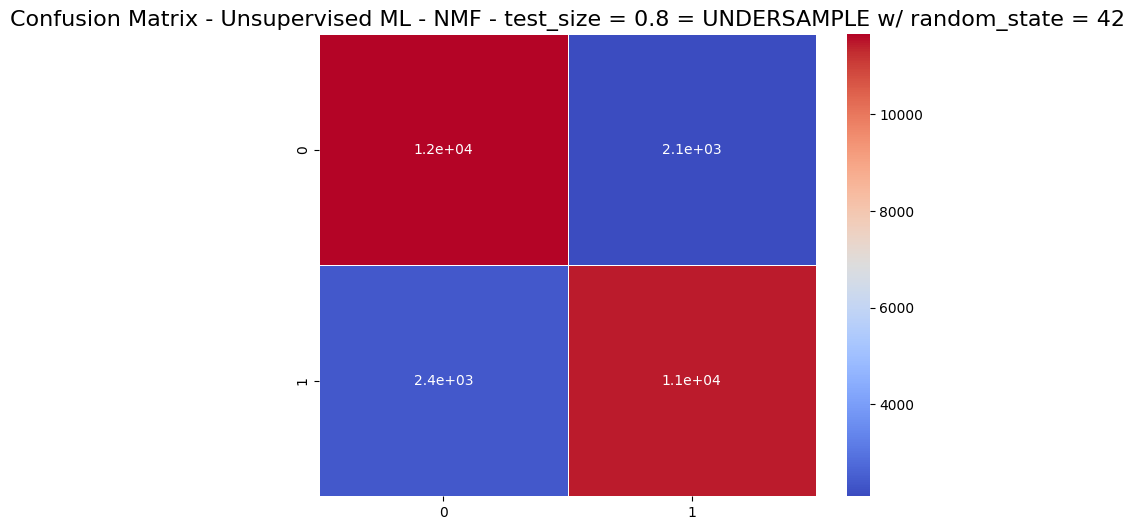

In [194]:
random_state = 42
test_size = 0.8
description = f"Unsupervised ML - NMF - test_size = {test_size} = UNDERSAMPLE w/ random_state = {random_state}"
df_COVID_dead = df_COVID[df_COVID["DIED"]==1]
df_COVID_alive = df_COVID[df_COVID["DIED"]!=1]
df_COVID_alive_sample = df_COVID_alive.sample(n=num_DEAD,random_state=random_state).reset_index().drop("index",axis=1) # UNDERSAMPLE
df = pd.concat([df_COVID_dead,df_COVID_alive_sample],axis=0).reset_index().drop("index",axis=1)
print(len(df))

X_train, X_test, y_train, y_test = get_split(df,test_size=test_size,random_state=random_state)

n_components = len(df_COVID["DIED"].unique())
tfidvec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),tokenizer=word_tokenize,stop_words = 'english')
nmf_classifier = NMFClassifier(n_components=n_components)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidvec, 'SYMPTOMS'),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nmf', nmf_classifier)
])
param_grid = {
    'nmf__l1_ratio': [0.5, 0.0],
    'nmf__solver': ['mu'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
}
custom_scorer = make_scorer(lambda y_true, yp: label_permute_score(y_true, yp, n=n_components))
grid_search = GridSearchCV(pipeline, param_grid, scoring=custom_scorer, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")
results = grid_search.cv_results_
print("Mean Test Scores for each parameter combination:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.3f}")

print("Individual fold scores:")
print(results['split0_test_score'])
print(results['split1_test_score'])
print(results['split2_test_score'])

acc_i,mapping_i = label_permute_score_perm(y_train, grid_search.predict(X_train), n=n_components)
print(acc_i,mapping_i)

accuracy_score_i = grid_search.score(X_test,y_test)
y_pred = grid_search.predict(X_test)
y_pred = [mapping_i.get(w) for w in y_pred]
print("Accuracy:",accuracy_score_i)
print(classification_report(y_test,y_pred))

i =len(df_results)
df_results.at[i,"Model"] = "Unsupervised - NMF"
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
# Amount trained on y_train==1 i.e. DIED; shows the imbalance is not there, but still learned well
print(1-len(y_train[y_train==1])/len(y_train))
print(1-len(y_test[y_test==1])/len(y_test))
balance_train = 1-len(y_train[y_train==1])/len(y_train)
balance_test = 1-len(y_test[y_test==1])/len(y_test)
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()

Best parameters: {'classifier__learning_rate': 0.1}
Accuracy: 0.933347830814396
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     13754
           1       0.97      0.90      0.93     13837

    accuracy                           0.93     27591
   macro avg       0.94      0.93      0.93     27591
weighted avg       0.94      0.93      0.93     27591

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     13754
           1       0.97      0.90      0.93     13837

    accuracy                           0.93     27591
   macro avg       0.94      0.93      0.93     27591
weighted avg       0.94      0.93      0.93     27591



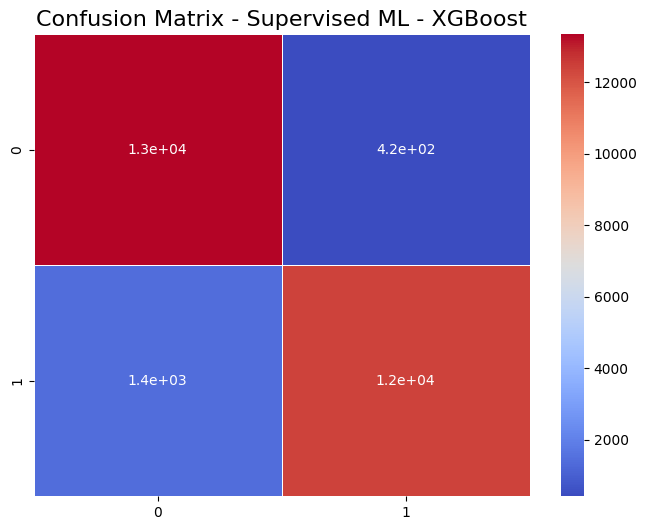

In [195]:
description = "Supervised ML - XGBoost"
param_grid = {
    'classifier__learning_rate': [0.05, 0.1]
}
xgb_clf = xgb.XGBClassifier(random_state=random_state)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_score_i =accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score_i)
print(classification_report(y_test, y_pred))
i =len(df_results)
df_results.at[i,"Model"] = description
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()

### 2.1.2 Unsupervised ML - NMF - test_size = 0.8 - UNDERSAMPLE w/ random_state = 43

34488
Best parameters: {'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}
Best accuracy: 0.83
Mean Test Scores for each parameter combination:
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.750
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.750
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.831
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.831
Individual fold scores:
[0.7477164  0.7477164  0.83862549 0.83862549]
[0.74641148 0.74641148 0.82905611 0.82905611]
[0.75554589 0.75554589 0.82514137 0.82514137]
0.8370305930114542 {0: 1, 1: 0}
Accuracy: 0.8410713638505309
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     13802
           1       0.85      0.83      0.84     13789

    accuracy                           0.84     27591
   macro avg       0.84      0.84      0.84

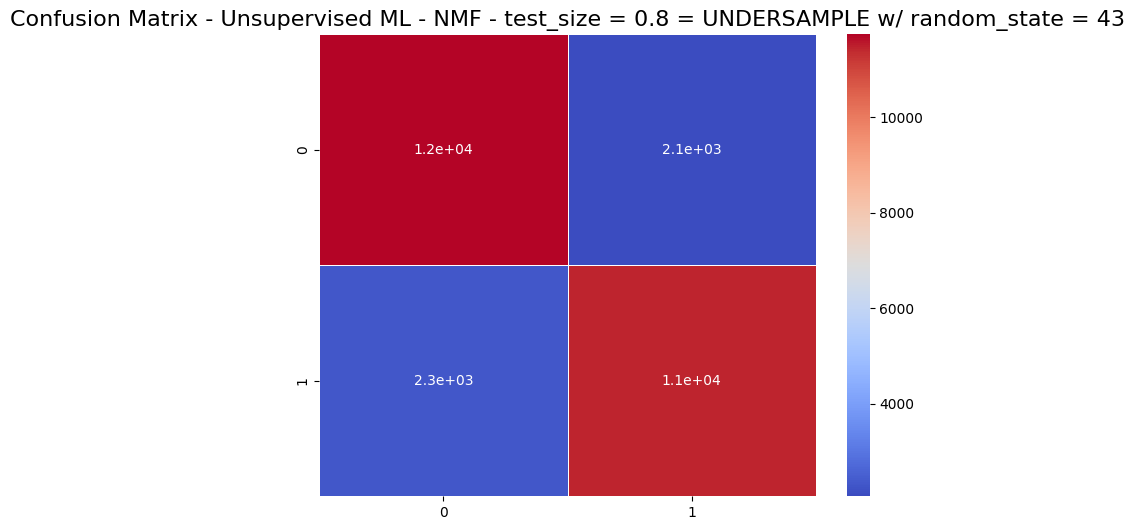

In [196]:
random_state = 43
test_size = 0.8
description = f"Unsupervised ML - NMF - test_size = {test_size} = UNDERSAMPLE w/ random_state = {random_state}"
df_COVID_dead = df_COVID[df_COVID["DIED"]==1]
df_COVID_alive = df_COVID[df_COVID["DIED"]!=1]
df_COVID_alive_sample = df_COVID_alive.sample(n=num_DEAD,random_state=random_state).reset_index().drop("index",axis=1) # UNDERSAMPLE
df = pd.concat([df_COVID_dead,df_COVID_alive_sample],axis=0).reset_index().drop("index",axis=1)
print(len(df))

X_train, X_test, y_train, y_test = get_split(df,test_size=test_size,random_state=random_state)

n_components = len(df_COVID["DIED"].unique())
tfidvec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),tokenizer=word_tokenize,stop_words = 'english')
nmf_classifier = NMFClassifier(n_components=n_components)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidvec, 'SYMPTOMS'),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nmf', nmf_classifier)
])
param_grid = {
    'nmf__l1_ratio': [0.5, 0.0],
    'nmf__solver': ['mu'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
}
custom_scorer = make_scorer(lambda y_true, yp: label_permute_score(y_true, yp, n=n_components))
grid_search = GridSearchCV(pipeline, param_grid, scoring=custom_scorer, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")
results = grid_search.cv_results_
print("Mean Test Scores for each parameter combination:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.3f}")

print("Individual fold scores:")
print(results['split0_test_score'])
print(results['split1_test_score'])
print(results['split2_test_score'])

acc_i,mapping_i = label_permute_score_perm(y_train, grid_search.predict(X_train), n=n_components)
print(acc_i,mapping_i)

accuracy_score_i = grid_search.score(X_test,y_test)
y_pred = grid_search.predict(X_test)
y_pred = [mapping_i.get(w) for w in y_pred]
print("Accuracy:",accuracy_score_i)
print(classification_report(y_test,y_pred))

i =len(df_results)
df_results.at[i,"Model"] = "Unsupervised - NMF"
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
# Amount trained on y_train==1 i.e. DIED; shows the imbalance is not there, but still learned well
print(1-len(y_train[y_train==1])/len(y_train))
print(1-len(y_test[y_test==1])/len(y_test))
balance_train = 1-len(y_train[y_train==1])/len(y_train)
balance_test = 1-len(y_test[y_test==1])/len(y_test)
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()


Best parameters: {'classifier__learning_rate': 0.1}
Accuracy: 0.9330941248957993
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     13802
           1       0.97      0.90      0.93     13789

    accuracy                           0.93     27591
   macro avg       0.94      0.93      0.93     27591
weighted avg       0.94      0.93      0.93     27591

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     13802
           1       0.97      0.90      0.93     13789

    accuracy                           0.93     27591
   macro avg       0.94      0.93      0.93     27591
weighted avg       0.94      0.93      0.93     27591



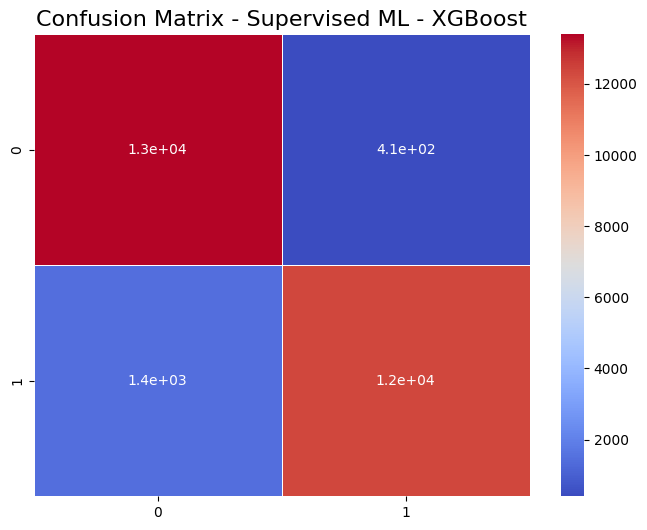

In [197]:
description = "Supervised ML - XGBoost"
param_grid = {
    'classifier__learning_rate': [0.05, 0.1]
}
xgb_clf = xgb.XGBClassifier(random_state=random_state)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_score_i =accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score_i)
print(classification_report(y_test, y_pred))
i =len(df_results)
df_results.at[i,"Model"] = description
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()

### 2.1.3 Unsupervised ML - NMF - test_size = 0.2 - UNDERSAMPLE w/ random_state = 42

34488
Best parameters: {'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}
Best accuracy: 0.85
Mean Test Scores for each parameter combination:
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.754
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.754
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.849
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.849
Individual fold scores:
[0.76003044 0.76003044 0.84603675 0.84603675]
[0.75981298 0.75981298 0.85386539 0.85386539]
[0.74304045 0.74304045 0.84602001 0.84602001]
0.8497281623776731 {0: 1, 1: 0}
Accuracy: 0.8424180922006379
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      3431
           1       0.86      0.82      0.84      3467

    accuracy                           0.84      6898
   macro avg       0.84      0.84      0.84

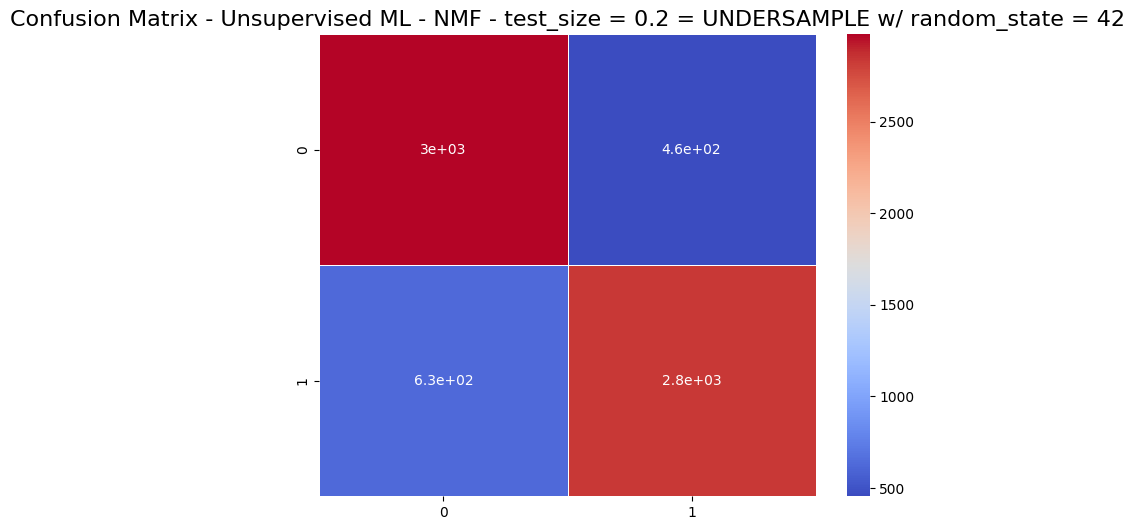

In [198]:
random_state = 42
test_size = 0.2
description = f"Unsupervised ML - NMF - test_size = {test_size} = UNDERSAMPLE w/ random_state = {random_state}"
df_COVID_dead = df_COVID[df_COVID["DIED"]==1]
df_COVID_alive = df_COVID[df_COVID["DIED"]!=1]
df_COVID_alive_sample = df_COVID_alive.sample(n=num_DEAD,random_state=random_state).reset_index().drop("index",axis=1) # UNDERSAMPLE
df = pd.concat([df_COVID_dead,df_COVID_alive_sample],axis=0).reset_index().drop("index",axis=1)
print(len(df))

X_train, X_test, y_train, y_test = get_split(df,test_size=test_size,random_state=random_state)

n_components = len(df_COVID["DIED"].unique())
tfidvec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),tokenizer=word_tokenize,stop_words = 'english')
nmf_classifier = NMFClassifier(n_components=n_components)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidvec, 'SYMPTOMS'),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nmf', nmf_classifier)
])
param_grid = {
    'nmf__l1_ratio': [0.5, 0.0],
    'nmf__solver': ['mu'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
}
custom_scorer = make_scorer(lambda y_true, yp: label_permute_score(y_true, yp, n=n_components))
grid_search = GridSearchCV(pipeline, param_grid, scoring=custom_scorer, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")
results = grid_search.cv_results_
print("Mean Test Scores for each parameter combination:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.3f}")

print("Individual fold scores:")
print(results['split0_test_score'])
print(results['split1_test_score'])
print(results['split2_test_score'])

acc_i,mapping_i = label_permute_score_perm(y_train, grid_search.predict(X_train), n=n_components)
print(acc_i,mapping_i)

accuracy_score_i = grid_search.score(X_test,y_test)
y_pred = grid_search.predict(X_test)
y_pred = [mapping_i.get(w) for w in y_pred]
print("Accuracy:",accuracy_score_i)
print(classification_report(y_test,y_pred))

i =len(df_results)
df_results.at[i,"Model"] = "Unsupervised - NMF"
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
# Amount trained on y_train==1 i.e. DIED; shows the imbalance is not there, but still learned well
print(1-len(y_train[y_train==1])/len(y_train))
print(1-len(y_test[y_test==1])/len(y_test))
balance_train = 1-len(y_train[y_train==1])/len(y_train)
balance_test = 1-len(y_test[y_test==1])/len(y_test)
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()


Best parameters: {'classifier__learning_rate': 0.1}
Accuracy: 0.9376630907509423
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3431
           1       0.97      0.90      0.94      3467

    accuracy                           0.94      6898
   macro avg       0.94      0.94      0.94      6898
weighted avg       0.94      0.94      0.94      6898

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3431
           1       0.97      0.90      0.94      3467

    accuracy                           0.94      6898
   macro avg       0.94      0.94      0.94      6898
weighted avg       0.94      0.94      0.94      6898



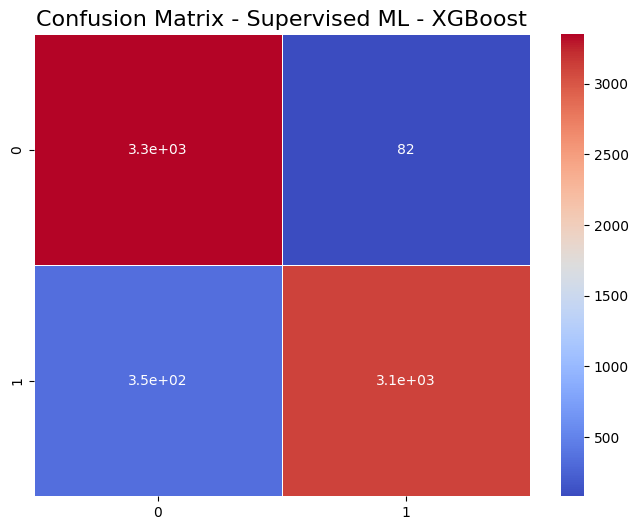

In [199]:
description = "Supervised ML - XGBoost"
param_grid = {
    'classifier__learning_rate': [0.05, 0.1]
}
xgb_clf = xgb.XGBClassifier(random_state=random_state)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_score_i =accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score_i)
print(classification_report(y_test, y_pred))
i =len(df_results)
df_results.at[i,"Model"] = description
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()

### 2.1.4 Unsupervised ML - NMF - test_size = 0.2 - IMBALANCED on ALL

910791
Best parameters: {'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}
Best accuracy: 0.86
Mean Test Scores for each parameter combination:
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.863
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.863
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.782
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.782
Individual fold scores:
[0.86353231 0.86353231 0.77886017 0.77886017]
[0.86275769 0.86275769 0.78808615 0.78808615]
[0.86300473 0.86300473 0.77944803 0.77944803]
0.863113341165362 {0: 0, 1: 1}
Accuracy: 0.8635587591060557
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    178758
           1       0.00      0.02      0.01      3401

    accuracy                           0.86    182159
   macro avg       0.49      0.45      0.47    182

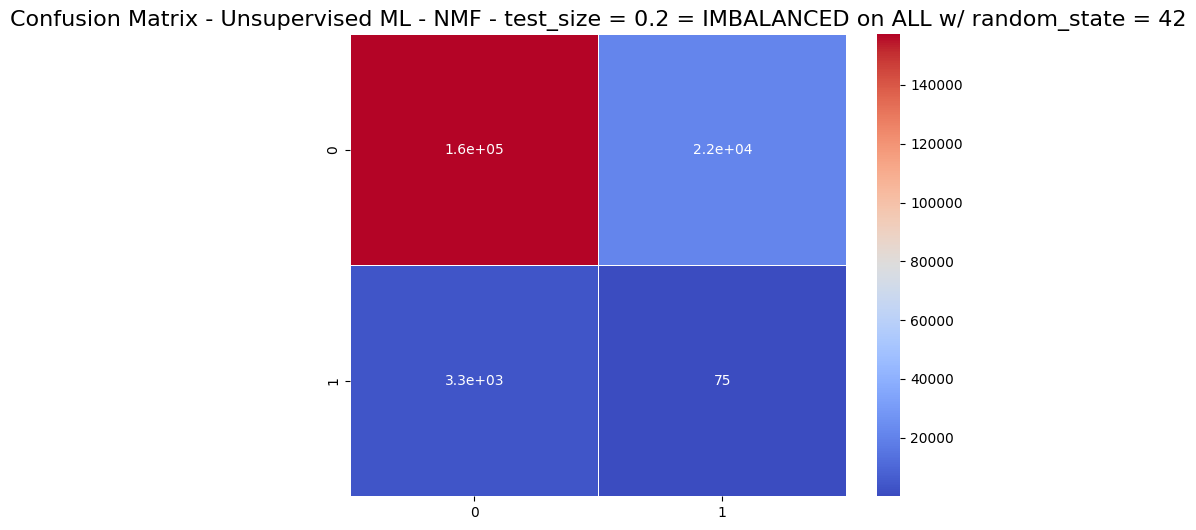

In [200]:
random_state = 42
test_size = 0.2
description = f"Unsupervised ML - NMF - test_size = {test_size} = IMBALANCED on ALL w/ random_state = {random_state}"
df_COVID_dead = df_COVID[df_COVID["DIED"]==1]
df_COVID_alive = df_COVID[df_COVID["DIED"]!=1]
df_COVID_alive_sample = df_COVID_alive.sample(n=num_DEAD,random_state=random_state).reset_index().drop("index",axis=1) # UNDERSAMPLE
df = pd.concat([df_COVID_dead,df_COVID_alive],axis=0).reset_index().drop("index",axis=1)
print(len(df))

X_train, X_test, y_train, y_test = get_split(df,test_size=test_size,random_state=random_state)

n_components = len(df_COVID["DIED"].unique())
tfidvec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),tokenizer=word_tokenize,stop_words = 'english')
nmf_classifier = NMFClassifier(n_components=n_components)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidvec, 'SYMPTOMS'),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nmf', nmf_classifier)
])
param_grid = {
    'nmf__l1_ratio': [0.5, 0.0],
    'nmf__solver': ['mu'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
}
custom_scorer = make_scorer(lambda y_true, yp: label_permute_score(y_true, yp, n=n_components))
grid_search = GridSearchCV(pipeline, param_grid, scoring=custom_scorer, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")
results = grid_search.cv_results_
print("Mean Test Scores for each parameter combination:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.3f}")

print("Individual fold scores:")
print(results['split0_test_score'])
print(results['split1_test_score'])
print(results['split2_test_score'])

acc_i,mapping_i = label_permute_score_perm(y_train, grid_search.predict(X_train), n=n_components)
print(acc_i,mapping_i)

accuracy_score_i = grid_search.score(X_test,y_test)
y_pred = grid_search.predict(X_test)
y_pred = [mapping_i.get(w) for w in y_pred]
print("Accuracy:",accuracy_score_i)
print(classification_report(y_test,y_pred))

i =len(df_results)
df_results.at[i,"Model"] = "Unsupervised - NMF"
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
# Amount trained on y_train==1 i.e. DIED; shows the imbalance is not there, but still learned well
print(1-len(y_train[y_train==1])/len(y_train))
print(1-len(y_test[y_test==1])/len(y_test))
balance_train = 1-len(y_train[y_train==1])/len(y_train)
balance_test = 1-len(y_test[y_test==1])/len(y_test)
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()


Best parameters: {'classifier__learning_rate': 0.1}
Accuracy: 0.9951416070575706
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178758
           1       0.99      0.75      0.85      3401

    accuracy                           1.00    182159
   macro avg       0.99      0.87      0.92    182159
weighted avg       1.00      1.00      0.99    182159

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178758
           1       0.99      0.75      0.85      3401

    accuracy                           1.00    182159
   macro avg       0.99      0.87      0.92    182159
weighted avg       1.00      1.00      0.99    182159



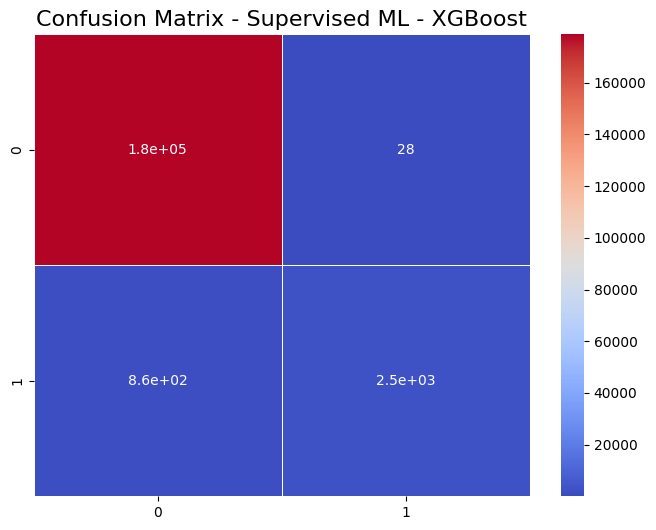

In [201]:
description = "Supervised ML - XGBoost"
param_grid = {
    'classifier__learning_rate': [0.05, 0.1]
}
xgb_clf = xgb.XGBClassifier(random_state=random_state)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_score_i =accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score_i)
print(classification_report(y_test, y_pred))
i =len(df_results)
df_results.at[i,"Model"] = description
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()

### 2.1.5 Unsupervised ML - NMF - test_size = 0.8 - IMBALANCED on ALL

910791
Best parameters: {'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}
Best accuracy: 0.86
Mean Test Scores for each parameter combination:
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.863
{'nmf__beta_loss': 'frobenius', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.863
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.5, 'nmf__solver': 'mu'}: 0.785
{'nmf__beta_loss': 'kullback-leibler', 'nmf__l1_ratio': 0.0, 'nmf__solver': 'mu'}: 0.785
Individual fold scores:
[0.8647892  0.8647892  0.79250659 0.79250659]
[0.86233304 0.86233304 0.78774354 0.78774354]
[0.8625142  0.8625142  0.77608327 0.77608327]
0.8631627488224508 {0: 0, 1: 1}
Accuracy: 0.863290572894722
              precision    recall  f1-score   support

           0       0.98      0.88      0.93    714856
           1       0.00      0.02      0.01     13777

    accuracy                           0.86    728633
   macro avg       0.49      0.45      0.47    728

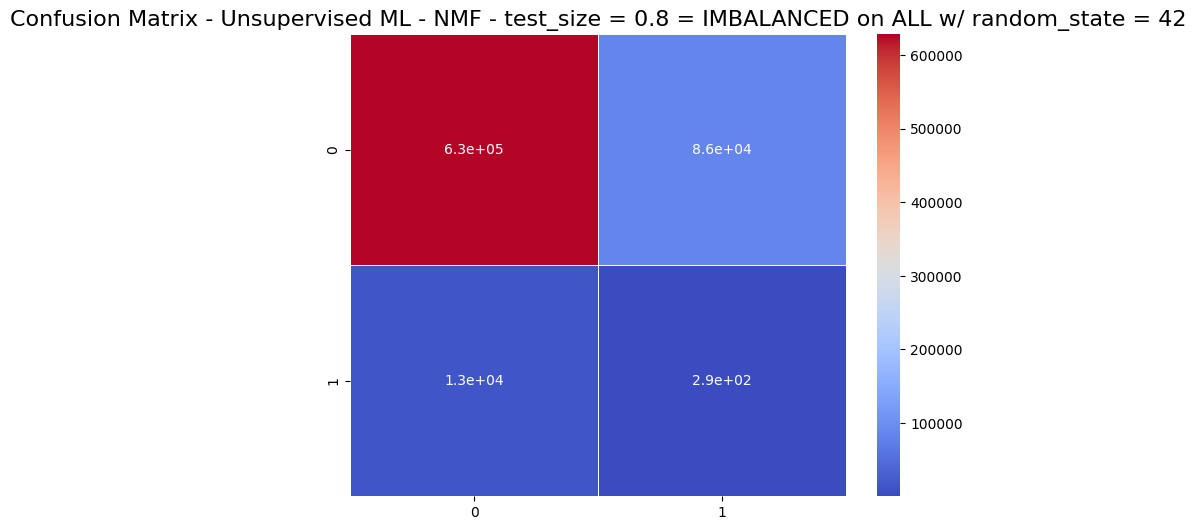

In [202]:
random_state = 42
test_size = 0.8
description = f"Unsupervised ML - NMF - test_size = {test_size} = IMBALANCED on ALL w/ random_state = {random_state}"
df_COVID_dead = df_COVID[df_COVID["DIED"]==1]
df_COVID_alive = df_COVID[df_COVID["DIED"]!=1]
df_COVID_alive_sample = df_COVID_alive.sample(n=num_DEAD,random_state=random_state).reset_index().drop("index",axis=1) # UNDERSAMPLE
df = pd.concat([df_COVID_dead,df_COVID_alive],axis=0).reset_index().drop("index",axis=1)
print(len(df))

X_train, X_test, y_train, y_test = get_split(df,test_size=test_size,random_state=random_state)

n_components = len(df_COVID["DIED"].unique())
tfidvec = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),tokenizer=word_tokenize,stop_words = 'english')
nmf_classifier = NMFClassifier(n_components=n_components)
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidvec, 'SYMPTOMS'),
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nmf', nmf_classifier)
])
param_grid = {
    'nmf__l1_ratio': [0.5, 0.0],
    'nmf__solver': ['mu'],
    'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
}
custom_scorer = make_scorer(lambda y_true, yp: label_permute_score(y_true, yp, n=n_components))
grid_search = GridSearchCV(pipeline, param_grid, scoring=custom_scorer, cv=3)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_:.2f}")
results = grid_search.cv_results_
print("Mean Test Scores for each parameter combination:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"{params}: {mean_score:.3f}")

print("Individual fold scores:")
print(results['split0_test_score'])
print(results['split1_test_score'])
print(results['split2_test_score'])

acc_i,mapping_i = label_permute_score_perm(y_train, grid_search.predict(X_train), n=n_components)
print(acc_i,mapping_i)

accuracy_score_i = grid_search.score(X_test,y_test)
y_pred = grid_search.predict(X_test)
y_pred = [mapping_i.get(w) for w in y_pred]
print("Accuracy:",accuracy_score_i)
print(classification_report(y_test,y_pred))

i =len(df_results)
df_results.at[i,"Model"] = "Unsupervised - NMF"
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
# Amount trained on y_train==1 i.e. DIED; shows the imbalance is not there, but still learned well
print(1-len(y_train[y_train==1])/len(y_train))
print(1-len(y_test[y_test==1])/len(y_test))
balance_train = 1-len(y_train[y_train==1])/len(y_train)
balance_test = 1-len(y_test[y_test==1])/len(y_test)
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()


Best parameters: {'classifier__learning_rate': 0.1}
Accuracy: 0.9949714053577041
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    714856
           1       0.98      0.75      0.85     13777

    accuracy                           0.99    728633
   macro avg       0.99      0.87      0.92    728633
weighted avg       0.99      0.99      0.99    728633

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    714856
           1       0.98      0.75      0.85     13777

    accuracy                           0.99    728633
   macro avg       0.99      0.87      0.92    728633
weighted avg       0.99      0.99      0.99    728633



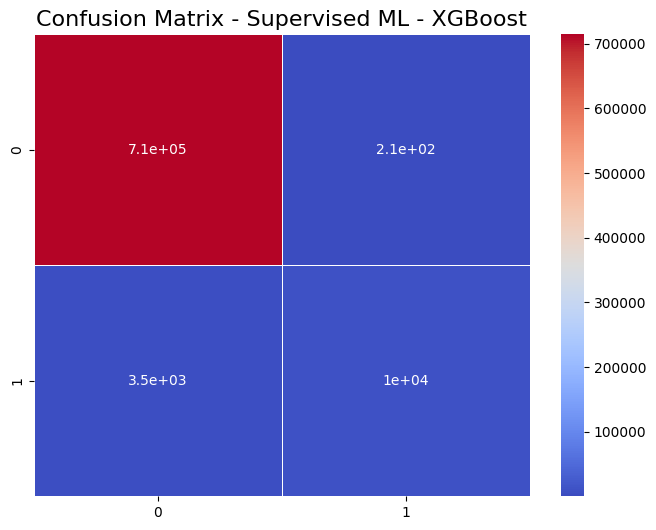

In [203]:
description = "Supervised ML - XGBoost"
param_grid = {
    'classifier__learning_rate': [0.05, 0.1]
}
xgb_clf = xgb.XGBClassifier(random_state=random_state)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy_score_i =accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score_i)
print(classification_report(y_test, y_pred))
i =len(df_results)
df_results.at[i,"Model"] = description
df_results.at[i,"test_size"] = test_size
df_results.at[i,"accuracy"] = accuracy_score_i
df_results.at[i,"random_state"] = random_state
df_results.at[i,"description"] = description
df_results.at[i,"balance_test"] = balance_test
df_results.at[i,"balance_train"] = balance_train
cr_i = classification_report(y_test, y_pred)
print(cr_i)
f1_score_1 = float(cr_i.split("accuracy")[0].split("\n           1")[1].split("     ")[3])
df_results.at[i,"f1_score_1"] = f1_score_1
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title(f'Confusion Matrix - {description}', fontsize=16)
plt.show()


# 3.0 Results

* We saw in the previous section that out of the **Unsupervised ML** method with **NMF** vs. the **Supervised ML** method with *XGBoostClassifier*, that the *XGBoostClassifier* did the best job at handling the data for creating a model that could predict if a patient was likely to die give their symptoms, vaccine information, and personal health history. 

* However, it was interesting how little data was required for **NMF** to do so well on the test set.  This suggests that it could learn the underlying features with a few examples better than most traditional supervised ML approaches.


* From this we then were able to address the class imbalance above undersampling to the smaller class, **DIED** above and perform a GridSearch to see which scaled weight hyperparameter would give the best model in terms of it's *F1-Score*. 

* We also see that the different **random_states** didn't affect the outcome significantly, which is good.  So we can trust our **UNDERSAMPLING** results more. 

* Below is the result of our best hyperparameter search and model.  We see that the model has a higher *Recall* than the previous trained models and *F1-score*.  As mentioned earlier these metrics are important for the model's performance since we do not want to miss people that could likely die given their symptoms, healthy history, and vaccine information.  Thus, we care less about *False Positives* for **DIED** and more about not missing people.  So the *F1-Score* was chosen as the metrics to optimize.

In [204]:
df_results.sort_values(by="f1_score_1",ascending=False)

,Model,test_size,accuracy,random_state,description,balance_test,balance_train,f1_score_1
5,Supervised ML - XGBoost,0.2,0.937663,42,Supervised ML - XGBoost,0.497391,0.500652,0.94
1,Supervised ML - XGBoost,0.8,0.933348,42,Supervised ML - XGBoost,0.498496,0.506017,0.93
3,Supervised ML - XGBoost,0.8,0.933094,43,Supervised ML - XGBoost,0.500236,0.499058,0.93
7,Supervised ML - XGBoost,0.2,0.995142,42,Supervised ML - XGBoost,0.981329,0.981001,0.85
9,Supervised ML - XGBoost,0.8,0.994971,42,Supervised ML - XGBoost,0.981092,0.980967,0.85
0,Unsupervised - NMF,0.8,0.837556,42,Unsupervised ML - NMF - test_size = 0.8 = UNDE...,0.498496,0.506017,0.84
2,Unsupervised - NMF,0.8,0.841071,43,Unsupervised ML - NMF - test_size = 0.8 = UNDE...,0.500236,0.499058,0.84
4,Unsupervised - NMF,0.2,0.842418,42,Unsupervised ML - NMF - test_size = 0.2 = UNDE...,0.497391,0.500652,0.84
6,Unsupervised - NMF,0.2,0.863559,42,Unsupervised ML - NMF - test_size = 0.2 = IMBA...,0.981329,0.981001,0.01
8,Unsupervised - NMF,0.8,0.863291,42,Unsupervised ML - NMF - test_size = 0.8 = IMBA...,0.981092,0.980967,0.01


# 4.0 Discussion/Conclusion

* The goal was to determine if we could make a **UNSUPERVISED ML** model that could leverage the data in an unbiased was for predicting if a person would die or not given their health history, symptoms, and vaccine information using the VAERS dataset.  This proved to be difficult because of the imbalance in the dataset for people that died vs. people who survived, less than 1% died from this dataset.

* In addition, there was a lot of data cleaning needed.  There were duplicate entries that had to be accounted for and data leakage in the symptoms for indicating **death**.  We were able to catch these issues before model training by visualizing our data using TDIF for the text based entries and finding words like *death* leaked into the **SYMPTOMS** column.  We also were able to see where entries were duplicated using pandas to show duplicates.  

* If we were to train a model without accounting for these issues, we would produce a model that would appear on the surface to have high accuracy, precision, recall, and F1-scores.  However, we did our best to remove the bias from our data and make it fair as possible to train on.  

* We trained 2 different types of models, **NMF** (Unsupervised ML) and **XGBoostClassifier**(Supervised ML).  We accounted for class imbalance by **UNDERSAMPLING** our data. We also did a **Hyperparameter** search with GridSearchCV to determine appropriate values based on the  best model with respect to F1-score, precision, recall, and accuracy.    

* In conclusion, this was a fun dataset to work with and helped create a meaningful model based on the COVID19 vaccines for determining the probability a patient with adverse reactions to a COVID19 vaccine would die or not based on their symptoms and personal health history.  The model has a lot of room for improvement, but gives us insight into some of the things that appear to matter most for patient with adverse reactions like if they have to go to the hospital and how old they are.  